<a href="https://colab.research.google.com/github/Samuel-Solomon-1/Project-2-Data-Cleaning-and-Preparation/blob/main/Project_2_Data_Cleaning_and_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Data Cleaning and Preparation

## Project Overview

In this project, we refine the stock price dataset prepared in Project 1 for advanced modeling and analytics. This involves comprehensive data cleaning, transformation, feature engineering, and formatting to ensure the dataset meets the requirements for machine learning applications.

By the end of this notebook, we aim to:
- Ensure data integrity and remove noise
- Engineer useful features (e.g., moving averages, volatility)
- Normalize and encode features appropriately
- Prepare final clean datasets for training, validation, and testing

## Input

- `historical_stock_prices.csv`
- `historical_stocks.csv`  
(*Cleaned and pre-processed from Project 1*)

## Workflow Overview

1. **Advanced Data Cleaning**
   - Handle missing values with appropriate imputation strategies
   - Detect and manage outliers in price and volume
   - Identify and correct anomalies or errors

2. **Data Transformation**
   - Feature engineering (rolling averages, volatility, indicators)
   - Normalize and standardize numeric columns
   - Encode categorical fields (e.g., exchange, sector)

3. **Integration and Formatting**
   - Merge all cleaned and engineered features
   - Split into train/validation/test sets
   - Save final datasets for modeling

4. **Documentation & Reporting**
   - Explain each method used
   - Include visualizations
   - Summarize decisions and implications

## Task 1: Advanced Data Cleaning

This step ensures our dataset is accurate, consistent, and ready for analytical modeling.

### 1.1 Handle Missing Values
We will identify missing values in both datasets and apply advanced imputation techniques:
- `forward-fill` or `backward-fill` for time-series continuity
- `interpolation` for numerical sequences
- Leave categorical columns as `NaN` if domain imputation isn't safe

### 1.2 Detect and Resolve Outliers
We’ll use:
- **Z-score method** and **Interquartile Range (IQR)** for numeric outliers
- Visual inspection via boxplots and histograms

We will apply:
- **Capping** (e.g., 1st and 99th percentile)
- **Log transformation** to reduce skew (if applicable)

### 1.3 Error Identification and Correction
We’ll scan for:
- Negative `volume`
- Implausible values (e.g., zero or negative prices)
- Duplicates or misaligned dates

Corrections will be logged and verified visually/statistically.

Missing values in stocks dataset:
ticker         0
exchange       0
name           0
sector      1440
industry    1440
dtype: int64

Missing values in prices dataset:
ticker       0
open         0
close        0
adj_close    0
low          0
high         0
volume       0
date         0
dtype: int64

Invalid rows detected: 0
Removed 0 duplicate rows.


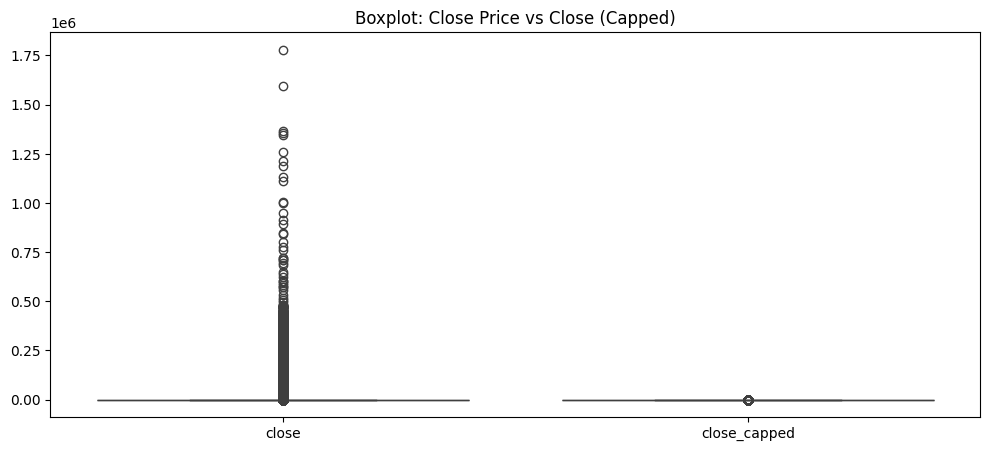

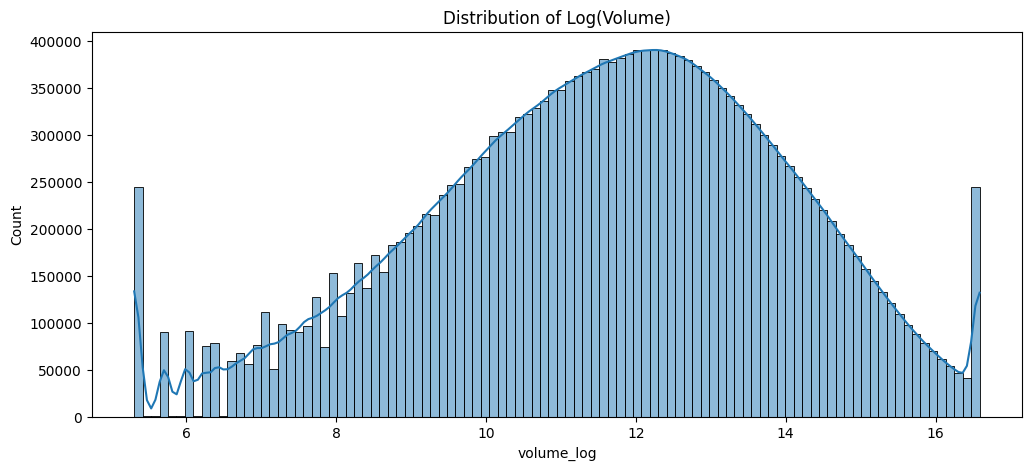

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reload datasets from Project 1 (update paths if needed)
stocks_path = '/content/drive/MyDrive/historical_stocks.csv'
prices_path = '/content/drive/MyDrive/historical_stock_prices.csv'

stocks_df = pd.read_csv(stocks_path)
prices_df = pd.read_csv(prices_path, parse_dates=['date'])

# ------------------------
# 1.1 Handle Missing Values
# ------------------------

print("Missing values in stocks dataset:")
print(stocks_df.isnull().sum())

print("\nMissing values in prices dataset:")
print(prices_df.isnull().sum())

# Handle missing sector/industry in stocks_df
stocks_df['sector'] = stocks_df['sector'].fillna('Unknown')
stocks_df['industry'] = stocks_df['industry'].fillna('Unknown')

# No missing values in prices_df, so no imputation needed

# ------------------------
# 1.2 Detect & Resolve Outliers
# ------------------------

def cap_outliers(df, col, lower_pct=0.01, upper_pct=0.99):
    lower = df[col].quantile(lower_pct)
    upper = df[col].quantile(upper_pct)
    return df[col].clip(lower=lower, upper=upper)

# Cap extreme outliers
for col in ['close', 'volume']:
    prices_df[f'{col}_capped'] = cap_outliers(prices_df, col)

# Log transform volume for later modeling (optional)
prices_df['volume_log'] = np.log1p(prices_df['volume_capped'])

# ------------------------
# 1.3 Error Detection & Correction
# ------------------------

# Detect rows with negative or zero prices/volume
invalid_rows = prices_df[
    (prices_df['open'] <= 0) |
    (prices_df['high'] <= 0) |
    (prices_df['low'] <= 0) |
    (prices_df['close'] <= 0) |
    (prices_df['volume'] < 0)
]

print(f"\nInvalid rows detected: {len(invalid_rows)}")

# Remove invalid rows
prices_df = prices_df.drop(index=invalid_rows.index)

# Drop duplicates
before = len(prices_df)
prices_df.drop_duplicates(inplace=True)
after = len(prices_df)
print(f"Removed {before - after} duplicate rows.")

# ------------------------
# Visual Validation
# ------------------------

# Boxplot before/after capping
plt.figure(figsize=(12, 5))
sns.boxplot(data=prices_df[['close', 'close_capped']])
plt.title("Boxplot: Close Price vs Close (Capped)")
plt.show()

# Log-volume distribution
plt.figure(figsize=(12, 5))
sns.histplot(prices_df['volume_log'], bins=100, kde=True)
plt.title("Distribution of Log(Volume)")
plt.show()

## Task 2: Data Transformation

To prepare the dataset for predictive modeling, we apply transformations to enhance the signal quality and consistency of features.

### 2.1 Feature Engineering
We create new variables that help capture patterns and relationships:
- **Rolling Averages** (7-day and 30-day)
- **Volatility Measures** (rolling standard deviation)
- **Daily Return** percentage change

### 2.2 Data Normalization / Standardization
To ensure fair feature contribution, we normalize continuous variables like `close` and `volume` using standard scaling techniques.

### 2.3 Encoding Categorical Variables
We one-hot encode fields such as:
- `exchange` (e.g., NASDAQ, NYSE)
- `sector` or `industry`

This ensures compatibility with ML models that require numeric inputs.

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np

# ----------------------------
# 2.1 Feature Engineering
# ----------------------------

# Sort by ticker and date to compute rolling features
selected_tickers = [
    'AAPL',  # Apple
    'GOOG',  # Google (Alphabet)
    'MSFT',  # Microsoft
    'AMZN',  # Amazon
    'TSLA',  # Tesla
    'META',  # Meta (Facebook)
    'NFLX',  # Netflix
    'NVDA',  # NVIDIA
    'INTC',  # Intel
    'IBM',   # IBM
    'AMD',   # Advanced Micro Devices
    'ORCL',  # Oracle
    'BA',    # Boeing
    'JPM',   # JPMorgan Chase
    'BAC',   # Bank of America
    'WMT',   # Walmart
    'DIS',   # Disney
    'PFE',   # Pfizer
    'NKE',   # Nike
    'KO'     # Coca-Cola
]

prices_df = prices_df[prices_df['ticker'].isin(selected_tickers)].copy()

prices_df.sort_values(['ticker', 'date'], inplace=True)

# Compute 7-day and 30-day rolling averages for closing price
prices_df['rolling_7'] = prices_df.groupby('ticker')['close'].transform(lambda x: x.rolling(window=7).mean())
prices_df['rolling_30'] = prices_df.groupby('ticker')['close'].transform(lambda x: x.rolling(window=30).mean())

# Rolling standard deviation as a proxy for volatility
prices_df['volatility_7'] = prices_df.groupby('ticker')['close'].transform(lambda x: x.rolling(window=7).std())

# Daily return as percentage change
prices_df['daily_return'] = prices_df.groupby('ticker')['close'].transform(lambda x: x.pct_change())

# Drop rows with NaN introduced by rolling (optional or can keep)
prices_df.dropna(subset=['rolling_7', 'rolling_30', 'volatility_7', 'daily_return'], inplace=True)

# ----------------------------
# 2.2 Data Normalization
# ----------------------------

# We'll normalize close, volume_capped, and daily_return
scaler = StandardScaler()
prices_df[['close_scaled', 'volume_scaled', 'return_scaled']] = scaler.fit_transform(
    prices_df[['close', 'volume_capped', 'daily_return']]
)

# ----------------------------
# 2.3 Encoding Categorical Variables
# ----------------------------

# Merge sector and exchange from stocks_df
merged_df = prices_df.merge(
    stocks_df[['ticker', 'exchange', 'sector']],
    on='ticker',
    how='left'
)

# One-hot encode exchange and sector
encoded_df = pd.get_dummies(merged_df, columns=['exchange', 'sector'], drop_first=True)

# Check final structure
print("Final transformed dataset shape:", encoded_df.shape)
print("Columns include:", encoded_df.columns.tolist()[:10])

Final transformed dataset shape: (165884, 24)
Columns include: ['ticker', 'open', 'close', 'adj_close', 'low', 'high', 'volume', 'date', 'close_capped', 'volume_capped']


## Task 3: Integration and Formatting for Modeling

In this final stage, we consolidate all feature engineering, encoding, and cleaning into one final dataset.

### 3.1 Consolidate Transformed Data
We ensure that all engineered and cleaned features are merged properly with the categorical encodings.

### 3.2 Data Splitting
Since we’re working with time-series stock data, we avoid shuffling and split the data based on time:
- **Training Set**: Older records
- **Validation Set**: Recent middle period
- **Test Set**: Most recent records

This allows evaluation that simulates real-world model deployment.

### 3.3 Save Processed Data
We save the clean and split datasets to `.csv` files for reuse in future modeling tasks.

In [7]:
import os
from sklearn.model_selection import train_test_split

# ----------------------------
# 3.1 Final Cleanup
# ----------------------------

# Remove any remaining NaNs
final_df = encoded_df.dropna().reset_index(drop=True)

# Optional: Drop unnecessary columns (e.g., original 'close', 'volume' if using scaled features)
columns_to_keep = ['date', 'ticker', 'close_scaled', 'volume_scaled', 'return_scaled',
                   'rolling_7', 'rolling_30', 'volatility_7'] + \
                  [col for col in encoded_df.columns if col.startswith('exchange_') or col.startswith('sector_')]

final_df = final_df[columns_to_keep]

# ----------------------------
# 3.2 Time-Aware Splitting
# ----------------------------

# Convert date to datetime if needed
final_df['date'] = pd.to_datetime(final_df['date'])

# Sort by date (just in case)
final_df.sort_values('date', inplace=True)

# Use date-based cutoff for splits
dates = final_df['date'].sort_values()
cutoff_train = dates.quantile(0.7)
cutoff_val = dates.quantile(0.85)

train_df = final_df[final_df['date'] <= cutoff_train]
val_df = final_df[(final_df['date'] > cutoff_train) & (final_df['date'] <= cutoff_val)]
test_df = final_df[final_df['date'] > cutoff_val]

print(f"Train set: {train_df.shape}")
print(f"Validation set: {val_df.shape}")
print(f"Test set: {test_df.shape}")

# ----------------------------
# 3.3 Save Final Datasets
# ----------------------------

# Define output directory
output_dir = '/content/drive/MyDrive/Project2'
os.makedirs(output_dir, exist_ok=True)

train_df.to_csv(f'{output_dir}/train_clean.csv', index=False)
val_df.to_csv(f'{output_dir}/val_clean.csv', index=False)
test_df.to_csv(f'{output_dir}/test_clean.csv', index=False)

print(f"Saved cleaned datasets to {output_dir}")

Train set: (116123, 14)
Validation set: (24891, 14)
Test set: (24870, 14)
Saved cleaned datasets to /content/drive/MyDrive/Project2


## Documentation and Reporting

### Overview

This project focused on cleaning, transforming, and preparing the historical stock price data for modeling. Building on the initial exploratory analysis from Project 1, this phase ensured the data is consistent, enriched, and structured for downstream machine learning tasks.

### Key Cleaning Steps

- **Missing Values**:  
  - Filled missing `sector` and `industry` with `'Unknown'` in the `stocks` dataset.
  - No missing values were found in `prices`, so no imputation was necessary.

- **Outlier Treatment**:  
  - Extreme values in `close` and `volume` were capped at the 1st and 99th percentiles to reduce the influence of noise.
  - Log-transformation was applied to `volume` to reduce skewness.

- **Error Correction**:  
  - Invalid records (e.g., non-positive prices or volumes) were removed.
  - Duplicate entries were dropped to prevent bias.

### Feature Engineering

- **Rolling Averages**: 7-day and 30-day moving averages of the `close` price per ticker.
- **Volatility**: 7-day rolling standard deviation of `close` prices.
- **Returns**: Daily percentage change in `close` prices.

These features were added to help models better understand temporal patterns in stock behavior.

### Data Transformation

- **Normalization**:  
  `close`, `volume`, and `returns` were scaled using `StandardScaler` to standardize feature ranges.

- **Categorical Encoding**:  
  - One-hot encoding was applied to `exchange` and `sector` for model compatibility.
  - This allows models to utilize categorical signals from industry segments and market exchanges.

### Integration and Splitting

- Merged price data with company metadata (`exchange`, `sector`).
- Sorted data chronologically and applied **time-based splitting** to simulate real-world forecasting:
  - **Training Set**: 70% oldest records
  - **Validation Set**: 15% middle period
  - **Test Set**: 15% most recent records

This approach respects the temporal nature of stock data and avoids data leakage.

### Outputs

- Cleaned and engineered datasets saved to:
  - `train_clean.csv`
  - `val_clean.csv`
  - `test_clean.csv`

### Conclusion

The dataset is now:
- Free from inconsistencies and invalid records
- Enriched with engineered features and indicators
- Properly encoded and scaled
- Formatted for use in machine learning models

This cleaned dataset is suitable for future predictive modeling tasks like price forecasting, volatility prediction, or sector-based analysis.